<h1 style="color:gold">Ex 6: Grover's Algorithm</h1>


Consider f(x) being a query to any kind of search-space, if f(x)=1 then x is the solution to our search, be it either an index in a data-base or the input to a more complex function.
The x for which f(x)=1 is by convention called ω


In [31]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.circuit.library import GroverOperator, MCMT, ZGate, XGate

import math as m
import matplotlib
import random

Input -> Grover -> oracle-check -> Result

In [32]:
def decompose_some_large_gate(circuit, gate, controls: list, targets: list, ancilas: list):
    if (len(targets) != 1 or len(controls) < 2): # Not dealing with this right now
        raise ValueError(msg="Not supported")

    initial_controls(circuit, gate, controls, targets, ancilas, 0)
    circuit.barrier()
    if (gate == 'x'):
        circuit.cx(ancilas[len(ancilas) - 1], targets[0])
    elif (gate == 'z'):
        circuit.cz(ancilas[len(ancilas) - 1], targets[0])
    circuit.barrier()
    reverse_controls(circuit, gate, controls, targets, ancilas, 0)

def initial_controls(circuit, gate, controls: list, targets: list, ancilas: list, depth: int):
    """
    Call with depth set to 0
    """
    ctrl_len = len(controls)
    anc_len = len(ancilas)

    if (ctrl_len - depth == 2):
        if (gate == 'x'):
            circuit.mcx([controls[0], controls[1]], ancilas[0])
        elif (gate == 'z'):
            circuit.cz([controls[0], controls[1]], ancilas[0])
    else:
        initial_controls(circuit, gate, controls, targets, ancilas, depth + 1)
        # Add Control on a new control-qbit and a previously used ancila
        if (gate == 'x'):
            circuit.mcx([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])
        elif (gate == 'z'):
            circuit.mcz([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])

def reverse_controls(circuit, gate, controls: list, targets: list, ancilas: list, depth: int):
    """
    Call with depth set to 0
    """
    ctrl_len = len(controls)
    anc_len = len(ancilas)

    if (ctrl_len - depth == 2):
        if (gate == 'x'):
            circuit.mcx([controls[0], controls[1]], ancilas[0])
        elif (gate == 'z'):
            circuit.mcz([controls[0], controls[1]], ancilas[0])
    else:
        # Add Control on a new control-qbit and a previously used ancila
        if (gate == 'x'):
            circuit.mcx([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])
        if (gate == 'z'):
            circuit.mcz([controls[ctrl_len - depth - 1], ancilas[anc_len- depth - 2]], ancilas[anc_len- depth - 1])
        reverse_controls(circuit, gate, controls, targets, ancilas, depth + 1)

In [33]:
def grover_oracle(oracle: QuantumCircuit, marked_states: list[str], num_qubits):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in the bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        if len(zero_inds) == 0:
            continue
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        oracle.x(zero_inds)
        # oracle.barrier()
        oracle.compose(MCMT(ZGate(), num_qubits - 1, 1).decompose(), inplace=True) # Produces c4z gates that cannot be executed
        # oracle.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True) # Produces c4z gates that cannot be executed
        # oracle.barrier()
        oracle.x(zero_inds)
    return oracle

In [34]:
def apply_diffusion_operator(oracle, num_qubits, ranges):
    n_range = range(num_qubits)

    diffused = oracle.copy()
    diffused.h(n_range)
    diffused.x(n_range)

    diffused.h(num_qubits - 1)
    # decompose_some_large_gate(diffused, 'x', ranges[0], ranges[1], ranges[2]) # Doesn't work for the decomposed MCMT ZGATE created by the oracle, bruh
    diffused.compose(MCMT(XGate(), num_qubits - 1, 1).decompose(), inplace=True)
    # diffused.compose(MCMT(XGate(), num_qubits - 1, 1), inplace=True)
    diffused.h(num_qubits - 1)

    diffused.x(n_range)
    diffused.h(n_range)
    return diffused

In [35]:
marked = ["010", "001"]
# marked = ["0000", "1000", "1001", "1010"]
for s in marked:
    if len(s) != len(marked[0]):
        raise ValueError(msg="Error")

nqbits = len(marked[0])
total_qbits = nqbits
print(f"nqbits: {nqbits}")
ranges = ()

###########################################3
### HOT-GARBAGE
# total_qbits += nqbits - 1 # If using Ancilas
# ctrl = QuantumRegister(nqbits - 1, 'control')
# target = QuantumRegister(1, 'target')
# ancilas = QuantumRegister(nqbits - 2, 'ancilas')
# c_range = [c for c in range(nqbits - 1)]
# t_range = [nqbits - 1]
# a_range = [c + nqbits for c in range(nqbits - 2)]
# ranges = (c_range, t_range, a_range)
# print(f"total_qbits: {nqbits + nqbits - 1}, c: {c_range}, a: {a_range}, t:{t_range}")
# oracle = QuantumCircuit(ctrl, target, ancilas)
###########################################3

oracle = QuantumCircuit(nqbits)
grover_oracle(oracle, marked, nqbits)
# oracle.barrier()
# oracle.draw() # Just way too big to draw

nqbits: 3


The diffusion reverse the bit-state changes that the oracle might made to Q, but it keeps the phase unchanged

In [36]:
grover_operator = apply_diffusion_operator(oracle, nqbits, ranges)
# grover_operator = GroverOperator(oracle).decompose()
# grover_operator.barrier()
print(f"depth: {grover_operator.depth()}")
grover_operator.draw()

depth: 36


┌───┐                                                     »
q_0: ┤ X ├──■───────────────────────────────────────────────■──»
     └───┘  │                                               │  »
q_1: ───────┼──────────────────────■────────────────────────┼──»
     ┌───┐┌─┴─┐┌────────────────┐┌─┴─┐┌──────────────────┐┌─┴─┐»
q_2: ┤ X ├┤ X ├┤ U(0,-π/8,-π/8) ├┤ X ├┤ U(0,-7π/8,-7π/8) ├┤ X ├»
     └───┘└───┘└────────────────┘└───┘└──────────────────┘└───┘»
«                                                ┌───┐          »
«q_0: ─────────────────────────────■─────────────┤ X ├───────■──»
«                                  │P(π/2)       ├───┤       │  »
«q_1: ────────────────────■────────■─────────────┤ X ├───────┼──»
«     ┌────────────────┐┌─┴─┐┌──────────────────┐├───┤┌───┐┌─┴─┐»
«q_2: ┤ U(0,-π/8,-π/8) ├┤ X ├┤ U(0,-7π/8,-7π/8) ├┤ X ├┤ X ├┤ X ├»
«     └────────────────┘└───┘└──────────────────┘└───┘└───┘└───┘»
«                                                                            »
«q_0: ─────────────────────────────────────────────■─────────────────────────»
«                                                  │                         »
«q_1: ────────────────────■────────────────────────┼──────────────────────■──»
«     ┌────────────────┐┌─┴─┐┌──────────────────┐┌─┴─┐┌────────────────┐┌─┴─┐»
«q_2: ┤ U(0,-π/8,-π/8) ├┤ X ├┤ U(0,-7π/8,-7π/8) ├┤ X ├┤ U(0,-π/8,-π/8) ├┤ X ├»
«     └────────────────┘└───┘└──────────────────┘└───┘└────────────────┘└───┘»
«                         ┌───┐┌───┐                                          »
«q_0: ──────■─────────────┤ H ├┤ X ├─────────────────────────────■────────────»
«           │P(π/2)       ├───┤├───┤┌───┐                        │            »
«q_1: ──────■─────────────┤ X ├┤ H ├┤ X ├────────────■───────────┼─────────■──»
«     ┌──────────────────┐├───┤├───┤├───┤┌───┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐»
«q_2: ┤ U(0,-7π/8,-7π/8) ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├»
«     └──────────────────┘└───┘└───┘└───┘└───┘└───┘└───┘└─────┘└───┘└───┘└───┘»
«                       ┌───┐      ┌───┐┌───┐
«q_0: ─────────■────■───┤ T ├───■──┤ X ├┤ H ├
«      ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐├───┤├───┤
«q_1: ─┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤ X ├┤ H ├
«     ┌┴───┴┐┌─┴─┐├───┤└┬───┬┘├───┤├───┤├───┤
«q_2: ┤ Tdg ├┤ X ├┤ T ├─┤ H ├─┤ H ├┤ X ├┤ H ├
«     └─────┘└───┘└───┘ └───┘ └───┘└───┘└───┘

Now create the grover circuit around the grover operator

In [37]:
N = 2**nqbits
n_range = range(nqbits)

# s is the number of solution
# N is the number of state
# t is the optimal iteration count
# p is the probability of correct measurment

s = len(marked)
if (s > 0): # If we know the number of solutions: s
    theta = m.asin(m.sqrt(s / N))
    t = m.floor(m.pi / (4 * theta))
    p = m.sin((2 * t + 1) * theta) ** 2
    print(f"Optimal iteration count: t = {t}, with probability of success p={p:0.6f}")
else: # Otherwise pick t at random in a this rangeL {1, pi*sqrt(N)/4}
    t = random.randrange(1, m.floor(m.pi*m.sqrt(N)/4), 1)
    print(f"Number of solutions not known, picking random: t = {t}, p is at least 0.4")

# Build the circuit and apply t times the gover-operation
grover_circuit = QuantumCircuit(total_qbits, nqbits)
grover_circuit.h(n_range) # Set the whole circuit in an undefined state
for _ in range(t):
    grover_circuit.compose(grover_operator, inplace=True)

grover_circuit.measure(n_range, n_range)
print(f"Depth: {grover_circuit.depth()}")
# grover_circuit.draw(output='mpl')


Optimal iteration count: t = 1, with probability of success p=1.000000
Depth: 38


## Run it on simulator

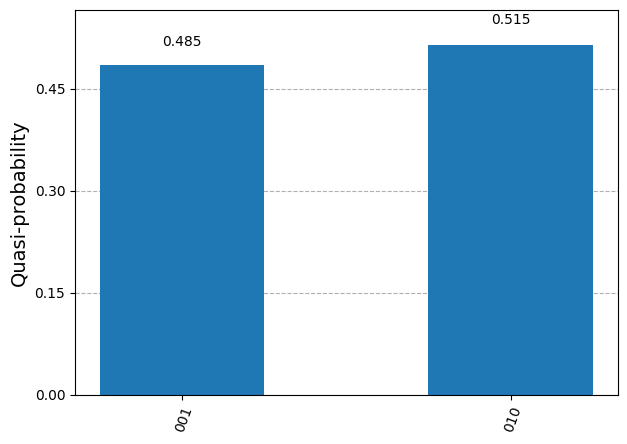

In [38]:
quasm_sim = AerSimulator()
circtui_aer = qiskit.transpile(grover_circuit, backend=quasm_sim)

counts = quasm_sim.run(grover_circuit).result().get_counts()
qiskit.visualization.plot_distribution(counts)

## Run it on a real Quantum-Computer

In [39]:
# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# print(f"Runing simulation on: {backend.name}")

Runing simulation on: ibm_sherbrooke


In [40]:
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=3)

# circuit_isa = pm.run(grover_circuit)
# print(f"grover_circuit depth: {grover_circuit.depth()}\nIsa transpiled depth: {circuit_isa.depth()}")

In [41]:
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 5_000
# job = sampler.run([circuit_isa])
# print(f"Job_id: {job.job_id()}")

In [42]:
service = QiskitRuntimeService()

## 2 bits, oracle:["01"]
# job = service.job('cvpy5p620wjg008q2g5g')# 500 shots

## 3 bits, oracle:["011", "100"]
job = service.job('cvp1syq20wjg008q0w8g') # 100 shots

## ERROR :/, circuit is 741,699 depth, it is best contained abot not much more than a thousand
# 12 bits, oracle:["000000000000", "000000100000", "000000100001", "000000100010"]
# job = service.job('cvpxcxk20wjg008q2f80') #250 shots

## Didn't work on real device but works fine on simulators
# 4bits, oracle:["0000", "1000", "1001", "1010"], depth: 867
# job = service.job('cvpxt1855th0008rqbbg') # 500 shots
# job = service.job('cvqaaktzrmh0008g6ks0') # 5000 shots
# Still too big
# 4bits, oracle:["1101"], depth: 739
# job = service.job('cvqaw30zrmh0008g6mq0') # 5000 shots
## --> Conclusion, Deep circuit are too much suceptible to noise, and idk how to make smaller oracles



status = job.status()
print(f"Job status: {status}")

Job status: DONE


In [44]:
result = job.result()

counts = result[0].data.c.get_counts()
print(counts)

qiskit.visualization.plot_distribution(counts)

AttributeError: 'DataBin' object has no attribute 'get_counts'

## Why is it faster ?

The oracle inverse the phase so if the qbits states are: |0>,|0>,|0>,|0> the solutions will be marked as |0>,|0>,-|0>,|0>; 
When measured [|0>, -|0>]=0 and [|1>, -|1>]=1, the phase information is thus irrelevent to the phinal measurement.

However it can still be used be used, when we inverse a state, the mean value of the system will decrease.

The diffuser leverages this by flipping back the negative state not around the origin but around the mean, to balance itself out the system will reduce the probability of any other states to be at the mean.
The result is a decreased probabilty for all other states but increasing the solution-state by twice the mean. 